<h3>导入包</h3>

In [33]:
import os
import re
import logging
from typing import Optional, List, Dict
from datetime import datetime, date
import json
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, DateOffset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import DMatrix
import lightgbm as lgb
from lightgbm import Dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from lunarcalendar import Lunar


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

<h3>读取数据</h3>

<h4>读取给定数据</h4>

In [34]:
train_label = pd.read_csv("../data/A榜/train/A-入库流量（2014-2019）.csv")
test_label = DataFrame(index=pd.date_range(start="2020-01-01 00:00:00", end="2021-12-31 23:00:00", freq="H"), columns=["V"]).reset_index().rename(columns={"index": "TIME"})
logging.info(f"训练集入库流量数据{train_label.shape}")
logging.info(f"提交样例{test_label.shape}")

2025-03-16 17:39:47,055 : INFO : 训练集入库流量数据(52561, 14)
2025-03-16 17:39:47,056 : INFO : 提交样例(17544, 2)


<h4>读取外部数据</h4>

In [35]:
data_rain = pd.read_csv("../data/外部数据/open-meteo-rain.csv", skiprows=122)
locations = pd.read_csv("../data/外部数据/open-meteo-rain.csv", nrows=120)
locations.drop_duplicates(subset=["latitude", "longitude"])

,location_id,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,0,24.991210,117.707214,592.0,28800,Asia/Shanghai,GMT+8
1,1,25.834797,117.971640,293.0,28800,Asia/Shanghai,GMT+8
2,2,26.186290,118.223690,129.0,28800,Asia/Shanghai,GMT+8
3,3,26.256590,118.353460,104.0,28800,Asia/Shanghai,GMT+8
4,4,25.694199,118.792160,105.0,28800,Asia/Shanghai,GMT+8
...,...,...,...,...,...,...,...
114,114,25.694199,116.735580,385.0,28800,Asia/Shanghai,GMT+8
115,115,25.834797,116.793890,330.0,28800,Asia/Shanghai,GMT+8
117,117,26.045692,117.078780,509.0,28800,Asia/Shanghai,GMT+8
118,118,25.905096,117.117900,413.0,28800,Asia/Shanghai,GMT+8


<h3>数据预处理</h3>

<h4>处理标签</h4>

In [36]:
def process_time(df: DataFrame, mode: str = "x") -> DataFrame:
    """
    处理时间\n
    """
    result = df.copy()
    if "x" == mode:
        result["time"] = pd.to_datetime(result["time"])
    elif "y" == mode:
        result["TIME"] = pd.to_datetime(result["TIME"])
        result = result.set_index("TIME", drop=True)
        result = result.reindex(pd.date_range(start=result.index.min(), end=result.index.max(), freq="H"))
    else:
        raise ValueError(f"未知的参数mode={mode}")
    return result 

In [37]:
data_rain = process_time(data_rain, "x")
train_label = process_time(train_label, "y")
test_label = process_time(test_label, "y")

<h4>处理异常值</h4>

In [38]:
def process_outliers(df: DataFrame):
    """
    处理异常值\n
    """
    df[df[["V", "AVGV", "MAXV", "MINV", "S", "AVGS", "MAXS", "MINS"]] < 0] = np.nan

In [39]:
process_outliers(train_label)

<h3>探索性数据分析</h3>

<h4>入库流量分析</h4>

<Axes: >

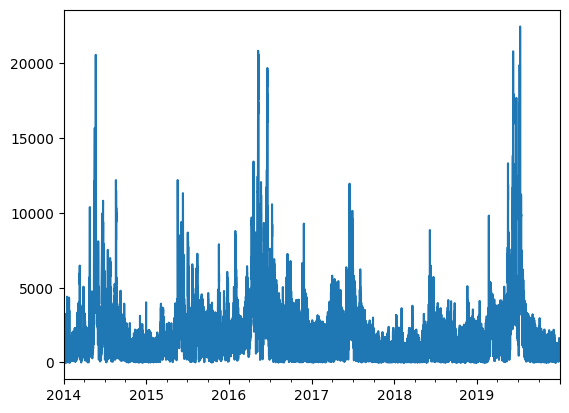

In [40]:
train_label["V"].plot()

<h4>降雨量分析</h4>

<Axes: >

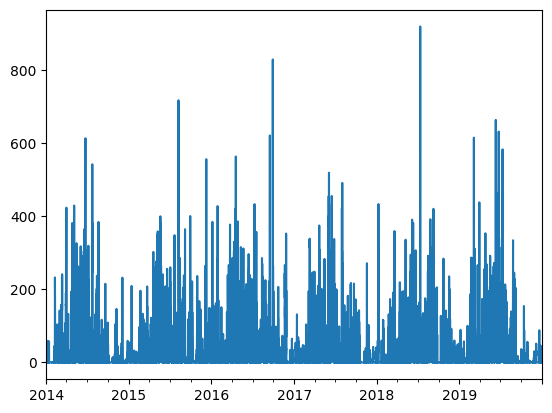

In [41]:
data_rain.groupby("time")["rain (mm)"].sum().reindex(train_label.index).plot()

<h3>特征工程</h3>

<h4>确实最佳lag</h4>

In [42]:
def best_lag_with_corr(x: DataFrame, y: DataFrame, max_lag: int) -> int:
    """
    确定x和y的最佳lag\n
    """
    df = pd.merge(x, y, how="right", left_index=True, right_index=True)
    corrs = []
    for i in range(0, max_lag + 1):
        df_new = df[["rain (mm)", "V"]].copy()
        if i > 0:
            df_new["V"] = df_new["V"].diff(i).shift(-i)
        df_new = df_new.dropna()
        df_new = (df_new - df_new.mean()) / df_new.std()
        corrs.append(df_new.corr().loc["rain (mm)", "V"])
    return range(0, max_lag + 1)[np.argmax(corrs)]

In [43]:
def best_lag_with_gbdt(x: DataFrame, y: DataFrame, max_lag: int) -> int:
    """
    确定x和y的最佳lag\n
    """
    x = x.copy()
    columns = [col.replace("_", "") for col in x.columns]
    for i in range(0, max_lag + 1):
        for column in columns:
            x[f"{column}_{i}"] = x[column].shift(i)
    df = pd.merge(x, y[["V"]], how="right", left_index=True, right_index=True)
    df = df.dropna()
    x = df.drop(columns=columns)
    y = x.pop("V")
    model = GradientBoostingRegressor(n_estimators=300, random_state=42)
    model.fit(x, y)
    best_feature = model.feature_names_in_[np.argmax(model.feature_importances_)]
    return int(best_feature.split("_")[1])

In [44]:
def best_lags_with_gbdt(x: DataFrame, y: DataFrame, max_lag: int, top_k: int) -> List[int]:
    """
    确定x和y的最佳lag\n
    """
    x = x.copy()
    columns = [col.replace("_", "") for col in x.columns]
    for i in range(0, max_lag + 1):
        for column in columns:
            x[f"{column}_{i}"] = x[column].shift(i)
    df = pd.merge(x, y[["V"]], how="right", left_index=True, right_index=True)
    df = df.dropna()
    x = df.drop(columns=columns)
    y = x.pop("V")
    model = GradientBoostingRegressor(n_estimators=300, random_state=42)
    model.fit(x, y)
    idxs = np.argpartition(model.feature_importances_, -top_k)[-top_k:]
    best_features = model.feature_names_in_[idxs]
    return [int(x.split("_")[1]) for x in best_features]

<h4>农历特征</h4>

In [45]:
def lunar_features(df: DataFrame) -> DataFrame:
    """
    农历特征\n
    """
    result = df.copy()
    result["lunar_year"] = result.index.to_series().apply(lambda x: Lunar.from_date(x).year)
    result["lunar_month"] = result.index.to_series().apply(lambda x: Lunar.from_date(x).month)
    result["lunar_day"] = result.index.to_series().apply(lambda x: Lunar.from_date(x).day)
    result["lunar_leap"] = result.index.to_series().apply(lambda x: Lunar.from_date(x).isleap)
    return result

<h4>不同站点横向拼接</h4>

In [46]:
def feature_engineering(x: DataFrame, y: DataFrame, lags_dict: Optional[Dict] = None) -> (DataFrame, Dict):
    """
    特征工程\n
    """
    results = []
    lag_results: Dict[str, List[int]] = dict()
    for location_id, df in tqdm(x.groupby("location_id")):
        df = df.set_index("time", drop=True).drop(columns=["location_id"])
        df = df.reindex(pd.date_range(start=y.index.min(), end=y.index.max(), freq="H"))
        if lags_dict is None:
            lags = best_lags_with_gbdt(df, y, 48, 24)
            lag_results[location_id] = lags
        else:
            if location_id not in lags_dict.keys():
                continue
            else:
                lags = lags_dict[location_id]
        for col in df.columns:
            for i in lags:
                df[f'{col}_shift{i}'] = df[col].shift(i)
        df = df.rename(columns={k: f"{k}_{location_id}" for k in df.columns})
        results.append(df)
    result = pd.concat(results, axis=1)
    columns = result.columns.copy()
    result["rain_sum"] = result[columns].sum(axis=1)
    result["rain_std"] = result[columns].std(axis=1)
    result["rain_median"] = result[columns].median(axis=1)
    result["rain_max"] = result[columns].max(axis=1)
    result["rain_skew"] = result[columns].skew(axis=1)
    result["rain_kurt"] = result[columns].kurt(axis=1)
    result["year"] = result.index.year
    result["month"] = result.index.month
    result["day"] = result.index.day
    result["hour"] = result.index.hour
    result[["year", "month", "day", "hour"]] = result[["year", "month", "day", "hour"]].astype("category")
    return result, lag_results

In [47]:
if os.path.exists("../data/lags_by_location.json"):
    with open("../data/lags_by_location.json", "r", encoding="utf-8") as f:
        lags_by_location = json.load(f)
        lags_by_location = {int(k): v for k, v in lags_by_location.items()}
    train_rain_group_by_location, _ = feature_engineering(data_rain, train_label, lags_by_location)
    test_rain_group_by_location, _ = feature_engineering(data_rain, test_label, lags_by_location)
else:
    train_rain_group_by_location, lags_by_location = feature_engineering(data_rain, train_label)
    test_rain_group_by_location, _ = feature_engineering(data_rain, test_label, lags_by_location)
    with open("../data/lags_by_location.json", "w", encoding="utf-8") as f:
        json.dump(lags_by_location, f)

  0%|          | 0/120 [00:00<?, ?it/s]

C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["rain_sum"] = result[columns].sum(axis=1)
C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["rain_std"] = result[columns].std(axis=1)
C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

  0%|          | 0/120 [00:00<?, ?it/s]

C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["rain_sum"] = result[columns].sum(axis=1)
C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result["rain_std"] = result[columns].std(axis=1)
C:\Users\DrZon\AppData\Local\Temp\ipykernel_14748\739385364.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

<h4>合并标签和特征</h4>

In [48]:
train_data = pd.merge(train_rain_group_by_location, train_label[["V"]], how="right", left_index=True, right_index=True)
test_data = pd.merge(test_rain_group_by_location, test_label[["V"]], how="right", left_index=True, right_index=True)
test_data = test_data.reindex(columns=train_data.columns)

<h4>划分xy</h4>

In [49]:
def split_xy(df: DataFrame, na_values: str = "fill") -> (DataFrame, Series):
    """
    划分xy\n
    """
    x = df.copy()
    if "fill" == na_values:
        y = x.pop("V")   
        y = y.fillna(method="bfill").fillna(method="ffill").fillna(0)
        x[x.select_dtypes(exclude=['category']).columns] = x[x.select_dtypes(exclude=['category']).columns].fillna(0).astype(np.float32)
    elif "drop" == na_values:
        x = x.dropna(how="all", subset=[x for x in x.columns if x not in ["year", "month", "day", "hour", "V"]])
        y = x.pop("V")
        y = y.fillna(method="bfill").fillna(method="ffill").fillna(0)
        x[x.select_dtypes(exclude=['category']).columns] = x[x.select_dtypes(exclude=['category']).columns].astype(np.float32)
    else:
        raise ValueError(f"未知的参数na_values={na_values}")
    return x, y

In [50]:
train_x, train_y = split_xy(train_data, "drop")
test_x, test_y = split_xy(test_data, "fill")

<h3>训练模型</h3>

<h4>评测指标</h4>

In [51]:
def score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return 1 / (1 + rmse)

<h4>lightgbm模型</h4>

In [52]:
params_lgb = {
    "num_boost_round": 300,
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 127,
    'verbose': -1,
    'seed': 42,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    "early_stopping_round": 100
}
model_lgb = []

<h4>xgboost模型</h4>

In [53]:
params_xgb = {
    "num_boost_round": 300,
    "learning_rate": 0.02,
    "booster": "gbtree",
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_leaves": 127,
    "verbosity": 1,
    "seed": 42,
    "nthread": -1,
    "colsample_bytree": 0.6,
    "subsample": 0.7,
    "early_stopping_rounds": 100
}
model_xgb = []

<h4>交叉验证</h4>

In [54]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

mse = 0
for fold, (train_index, val_index) in enumerate(kfold.split(train_x, train_y)):
    logging.info(f'############ fold: {fold} ###########')
    x_train, x_val, y_train, y_val = train_x.iloc[train_index], train_x.iloc[val_index], train_y.iloc[train_index], train_y.iloc[val_index]
    
    trainset = Dataset(x_train, y_train)
    valset = Dataset(x_val, y_val)
    model = lgb.train(params_lgb, trainset, valid_sets=[trainset, valset], categorical_feature="auto", callbacks=[lgb.log_evaluation(1000)])
    model.save_model("../models/lgb_%d.txt" % fold)
    model_lgb.append(model)
    lgb_pred = Series(model.predict(x_val, num_iteration=model.best_iteration), index=y_val.index).fillna(0)
    
    trainset = DMatrix(x_train, y_train, enable_categorical=True, nthread=-1)
    valset = DMatrix(x_val, y_val, enable_categorical=True, nthread=-1)
    model = xgb.train(params_xgb, trainset, evals=[(trainset, 'train'),(valset, 'eval')], num_boost_round=params_xgb["num_boost_round"], early_stopping_rounds=params_xgb["early_stopping_rounds"], verbose_eval=1000)
    model.save_model("../models/xgb_%d.json" % fold)
    model_xgb.append(model)
    xgb_pred = Series(model.predict(valset, iteration_range=(0, model.best_ntree_limit)), index=y_val.index).fillna(0)
    
    val_pred = (lgb_pred + xgb_pred) / 2
    mse += mean_squared_error(y_val.fillna(0), val_pred)
rmse = np.sqrt(mse / kfold.n_splits)
score = 1 / (1 + rmse)
logging.info(f"--------------本地分数 {score}--------------")

2025-03-16 18:27:12,676 : INFO : ############ fold: 0 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[18:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2762.80377	eval-rmse:2733.76435
[299]	train-rmse:749.15816	eval-rmse:931.70992


2025-03-16 18:30:05,850 : INFO : ############ fold: 1 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[18:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2746.87160	eval-rmse:2797.13401
[299]	train-rmse:746.81630	eval-rmse:955.07339


2025-03-16 18:32:59,549 : INFO : ############ fold: 2 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[18:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2750.58709	eval-rmse:2781.42929
[299]	train-rmse:744.96145	eval-rmse:937.05689


2025-03-16 18:35:40,678 : INFO : ############ fold: 3 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[18:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2776.05189	eval-rmse:2678.55425
[299]	train-rmse:747.94461	eval-rmse:927.15832


2025-03-16 18:38:36,475 : INFO : ############ fold: 4 ###########
C:\Program Files\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[18:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-rmse:2746.93682	eval-rmse:2797.15926
[299]	train-rmse:741.67740	eval-rmse:959.54323


2025-03-16 18:41:32,206 : INFO : --------------本地分数 0.0012431918413701197--------------


<h3>测试</h3>

<h4>计算测试集标签</h4>

In [55]:
y_pred = 0
for i in range(kfold.n_splits):
    lgb_pred = model_lgb[i].predict(test_x, num_iteration=model.best_iteration)
    xgb_pred = model_xgb[i].predict(DMatrix(test_x, enable_categorical=True, nthread=-1), iteration_range=(0, model.best_ntree_limit))
    y_pred += (lgb_pred + xgb_pred) / 2
y_pred = y_pred / kfold.n_splits

In [56]:
y_pred.shape

(17544,)

In [57]:
y_pred[y_pred < 0] = 0
test_label["V"] = y_pred
# test_label["V"].iloc[0:24] = train_label["V"].iloc[-24:]

<h4>保存文件</h4>

In [58]:
test_label[["V"]].to_csv(f"../data/submit/submit_{datetime.now().strftime('%Y%m%d-%H%M%S')}.csv", index_label="TIME")